# Supplementary Results

In [21]:
import pandas as pd
# remove warnings
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

In [22]:
def get_best_results(results, metric="bcc"):

    results["filter"] = results["filter"].replace("access", "Mandelli\cite{Mandelli2022}")
    results["filter"] = results["filter"].replace("matthias", "Kirchner\cite{Kirchner2008}")
    results["filter"] = results["filter"].replace("cross", "Bammey\cite{Bammey2024}")
    results["filter"] = results["filter"].replace("nlmeans", "Non-Local Means\cite{Nlmeans2005}")
    results["filter"] = results["filter"].replace("gaussian", "Gaussian")
    results["filter"] = results["filter"].replace("mean", "Mean")
    results["filter"] = results["filter"].replace("none", "No Extraction")
    results["filter"] = results["filter"].replace("pmap", "P-Map\cite{Popescu2005}")

    best_results = pd.DataFrame(columns=['feat', 'classifier', 'filter', 'bcc_mean', 'bcc_std', 'auc_mean', 'auc_std'])
    for feat in results.feat.unique():
        for classifier in results.classifier.unique():
            result = results[(results["feat"]==feat) & (results["classifier"]==classifier)]
            best_results = pd.concat([best_results, result[result[f"{metric}_mean"]==result[f"{metric}_mean"].max()]])
    best_results[f"{metric.upper()}"] = best_results[f"{metric}_mean"].map("{:.4f}".format) + " ± " + best_results[f"{metric}_std"].map("{:.4f}".format)
    best_results = best_results.drop(columns=["bcc_mean", "bcc_std", "auc_mean", "auc_std"])#,"filter", "mcc_mean", "mcc_std"])
    return best_results

def highlight_result(res, filter, feat, new_feat):
    hres = res[(res["filter"] == filter) & (res["feat"] == feat)]
    hres['feat'] = new_feat
    hres["BCC"] = hres["bcc_mean"].map("{:.4f}".format) + " ± " + hres["bcc_std"].map("{:.4f}".format)
    hres["AUC"] = hres["auc_mean"].map("{:.4f}".format) + " ± " + hres["auc_std"].map("{:.4f}".format)
    hres.drop(columns=["filter", "bcc_mean", "bcc_std", "auc_mean", "auc_std"], inplace=True)
    return hres

In [23]:
def plot_figures(data, exp_type):
    data_plot = data.copy()

    data_plot["feat"] = data_plot["feat"].replace("DINOV1", "DINOv1")
    data_plot["feat"] = data_plot["feat"].replace("DINOV2", "DINOv2")

    # sort data feat to order:
    data_plot["feat"] = data_plot["feat"].astype("category")
    data_plot["feat"] = data_plot["feat"].cat.reorder_categories(["DINOv1", "DINOv2", "CLIP", "GLCM", "FFT-PEAKS", 'FFT-GLCM', "PATCH-FFT-PEAKS"])

    # reorder filters
    data_plot["filter"] = data_plot["filter"].astype("category")
    data_plot["filter"] = data_plot["filter"].cat.reorder_categories(["No Extraction", "Gaussian", "Mean",  "Mandelli\cite{Mandelli2022}", "Bammey\cite{Bammey2024}", "P-Map\cite{Popescu2005}", "Kirchner\cite{Kirchner2008}", "Non-Local Means\cite{Nlmeans2005}"])

    if exp_type == "closed-set":
        data_plot["classifier"] = data_plot["classifier"].replace("RandomForestClassifier", "RF")
        data_plot["classifier"] = data_plot["classifier"].replace("XGBClassifier", "XGBoost")
        data_plot["classifier"] = data_plot["classifier"].replace("SVC", "SVM")
    else:
        data_plot["classifier"] = data_plot["classifier"].replace("IsolationForest", "IF")
        data_plot["classifier"] = data_plot["classifier"].replace("PCA", "PPCA")
        data_plot["classifier"] = data_plot["classifier"].replace("OneClassSVM", "SVM")

    
    plt.rcParams.update({'font.size': 18})
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    axes = ax.ravel()

    sns.set_context("paper")
    sns.set_style("whitegrid")
    sns.set_palette("colorblind")
    sns.set(font_scale=1)
    sns.set_style("ticks")

    
    for i, classifier in enumerate(data_plot.classifier.unique()):
        sns.barplot(x="feat", y="bcc_mean", hue="filter", data=data_plot[data_plot["classifier"]==classifier], ax=axes[i], 
                    alpha=0.6, dodge=True)
        # Get the coordinates of the tops of the bars
        for bar in ax[i].patches:
            x = bar.get_x() + bar.get_width() / 2  # get the center x-coordinate of the bar
            height = bar.get_height()  # get the height of the bar (y-coordinate of the top)
            if height > 0:
                ax[i].scatter(x, height, color=bar.get_facecolor(), edgecolor='w', marker=',',  s=30, alpha=1, zorder=10)
        
        
        ax[i].set_title(f"{classifier} - Bacc",  fontsize=18)
        ax[i].set_ylabel("Bacc", fontsize=16)
        ax[i].set_xlabel("Feature", fontsize=16)
        # remove legend
        ax[i].get_legend().remove()
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
        ax[i].tick_params(axis='both', which='major', labelsize=10)
        ax[i].set_ylim([0, 1])

    plt.legend(title="Residual Noise", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
    plt.savefig(f"{exp_type}_bcc.pdf", bbox_inches='tight', dpi=300)
    plt.show()

    plt.rcParams.update({'font.size': 18})
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    axes = ax.ravel()

    for i, classifier in enumerate(data_plot.classifier.unique()):
        sns.barplot(x="feat", y="auc_mean", hue="filter", data=data_plot[data_plot["classifier"]==classifier], ax=axes[i], 
                    alpha=0.6, dodge=True)
        # Get the coordinates of the tops of the bars
        for bar in ax[i].patches:
            x = bar.get_x() + bar.get_width() / 2  # get the center x-coordinate of the bar
            height = bar.get_height()  # get the height of the bar (y-coordinate of the top)
            if height > 0:
                ax[i].scatter(x, height, color=bar.get_facecolor(), edgecolor='w', marker=',',  s=30, alpha=1, zorder=10)
        
    
        ax[i].set_title(f"{classifier} - AUC",  fontsize=18)
        ax[i].set_ylabel("AUC", fontsize=16)
        ax[i].set_xlabel("Feature", fontsize=16)
        # remove legend
        ax[i].get_legend().remove()
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
        ax[i].tick_params(axis='both', which='major', labelsize=10)
        ax[i].set_ylim([0, 1])

    plt.legend(title="Residual Noise", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
    plt.savefig(f"{exp_type}_auc.pdf", bbox_inches='tight', dpi=300)
    plt.show()

### Closed-Set

In [24]:
# Closed Set
data = pd.read_csv("../closed_set.csv")
if "Unnamed: 0" in data.columns:
    data.drop(columns=["Unnamed: 0"], inplace=True)
results = pd.merge(get_best_results(data, "bcc"), get_best_results(data, "auc"), on=["feat", "classifier"])
results.drop(columns=["filter_x", "filter_y"], inplace=True)
# Mandelli et al results
mandelli_res = highlight_result(data, "Mandelli\cite{Mandelli2022}", "GLCM", "Mandelli et al.\cite{Mandelli2022}")
results = pd.concat([results, mandelli_res])
# Synthbuster results
synthbuster_res = highlight_result(data, "Bammey\cite{Bammey2024}", "FFT-PEAKS", "Synthbuster\cite{Bammey2024}")
results = pd.concat([results, synthbuster_res])
print(results.to_string())

                                  feat              classifier              BCC              AUC
0                            FFT-PEAKS  RandomForestClassifier  0.9885 ± 0.0007  0.9997 ± 0.0000
1                            FFT-PEAKS           XGBClassifier  0.9917 ± 0.0004  0.9999 ± 0.0000
2                            FFT-PEAKS                     SVC  0.9515 ± 0.0019  0.9984 ± 0.0001
3                             FFT-GLCM  RandomForestClassifier  0.9524 ± 0.0025  0.9977 ± 0.0001
4                             FFT-GLCM           XGBClassifier  0.9612 ± 0.0022  0.9984 ± 0.0001
5                             FFT-GLCM                     SVC  0.6925 ± 0.0003  0.9301 ± 0.0001
6                                 GLCM  RandomForestClassifier  0.9868 ± 0.0008  0.9996 ± 0.0000
7                                 GLCM           XGBClassifier  0.9909 ± 0.0009  0.9999 ± 0.0000
8                                 GLCM                     SVC  0.8004 ± 0.0046  0.9709 ± 0.0010
9                             

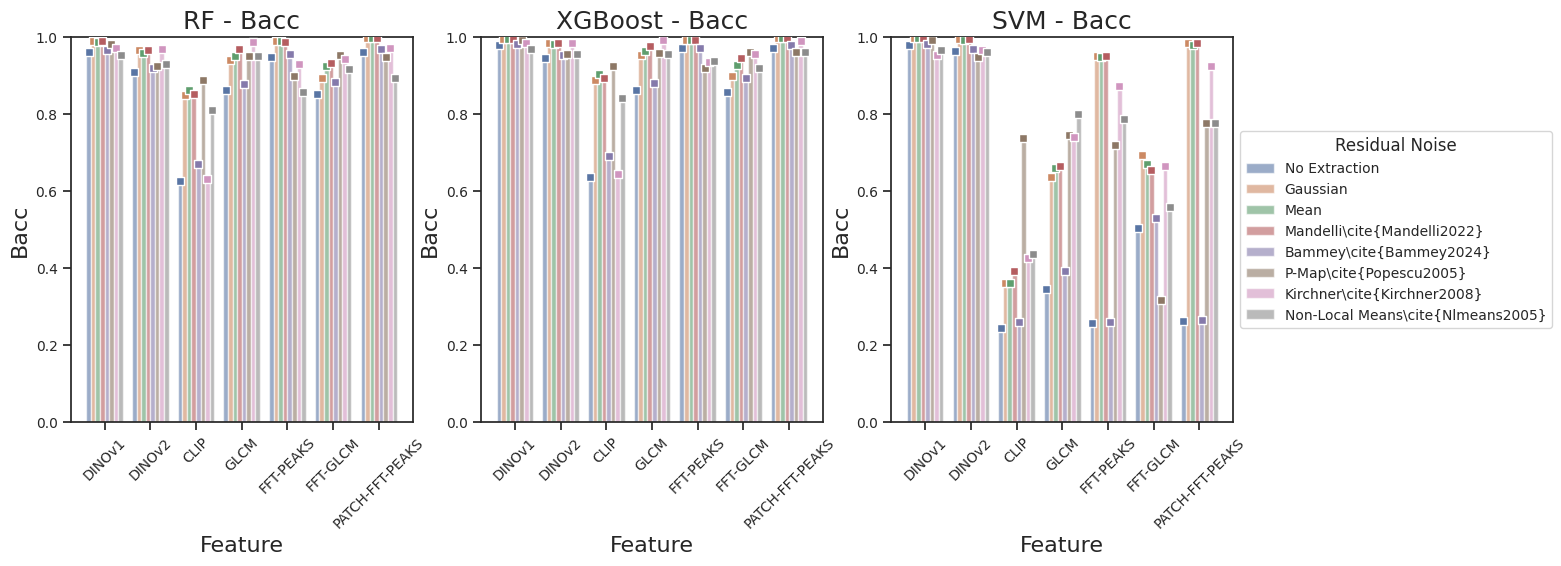

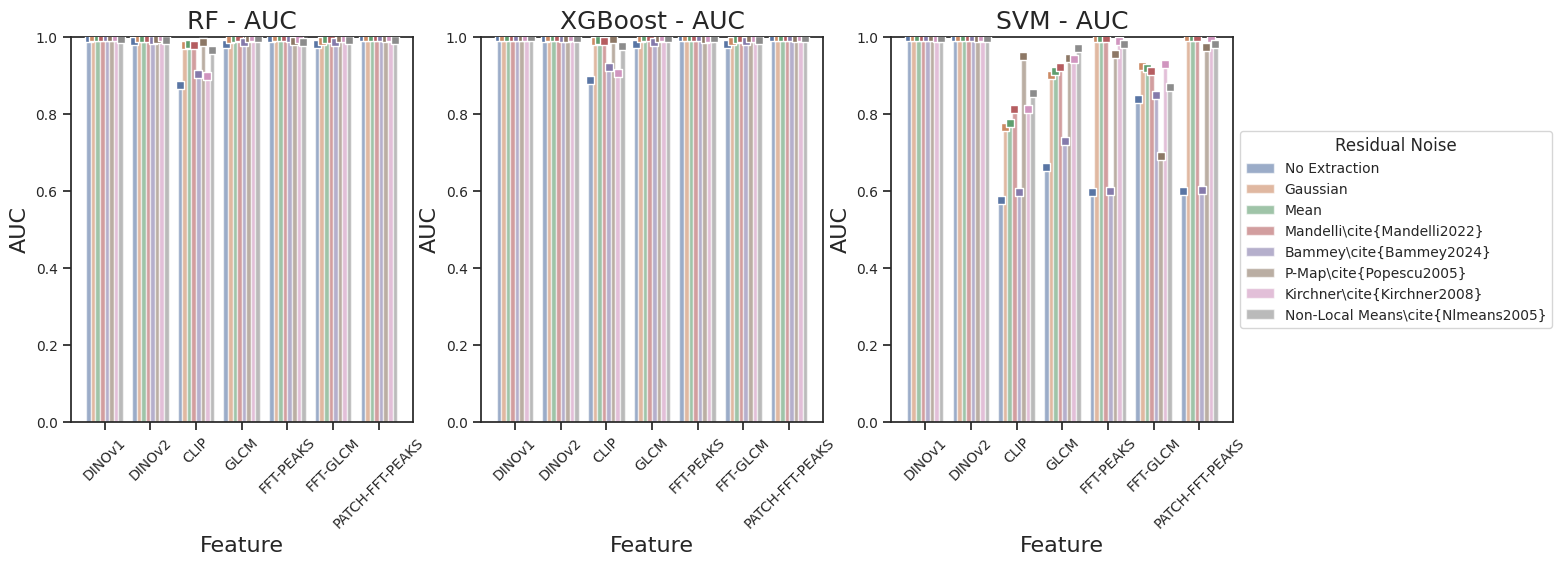

In [25]:
plot_figures(data, "closed-set")

----

### Open-Set

In [26]:
# Open Set
data = pd.read_csv("../open_set.csv")
if "Unnamed: 0" in data.columns:
    data.drop(columns=["Unnamed: 0"], inplace=True)
results = pd.merge(get_best_results(data, "bcc"), get_best_results(data, "auc"), on=["feat", "classifier"])
results.drop(columns=["filter_x", "filter_y"], inplace=True)
# Mandelli et al results
mandelli_res = highlight_result(data, "Mandelli\cite{Mandelli2022}", "GLCM", "Mandelli et al.\cite{Mandelli2022}")
results = pd.concat([results, mandelli_res])
# Synthbuster results
synthbuster_res = highlight_result(data, "Bammey\cite{Bammey2024}", "FFT-PEAKS", "Synthbuster\cite{Bammey2024}")
results = pd.concat([results, synthbuster_res])
print(results.to_string())

                                  feat       classifier              BCC              AUC
0                            FFT-PEAKS  IsolationForest  0.8561 ± 0.0163  0.9343 ± 0.0161
1                            FFT-PEAKS      OneClassSVM  0.8510 ± 0.0016  0.8892 ± 0.0053
2                            FFT-PEAKS              PCA  0.8653 ± 0.0214  0.9328 ± 0.0229
3                             FFT-GLCM  IsolationForest  0.8651 ± 0.0106  0.8905 ± 0.0209
4                             FFT-GLCM      OneClassSVM  0.7612 ± 0.0069  0.7886 ± 0.0623
5                             FFT-GLCM              PCA  0.8596 ± 0.0105  0.8850 ± 0.0079
6                                 GLCM  IsolationForest  0.7916 ± 0.0140  0.8563 ± 0.0259
7                                 GLCM      OneClassSVM  0.7301 ± 0.0079  0.7252 ± 0.0485
8                                 GLCM              PCA  0.8337 ± 0.0026  0.8751 ± 0.0161
9                               DINOV1  IsolationForest  0.7996 ± 0.0191  0.8473 ± 0.0030
10        

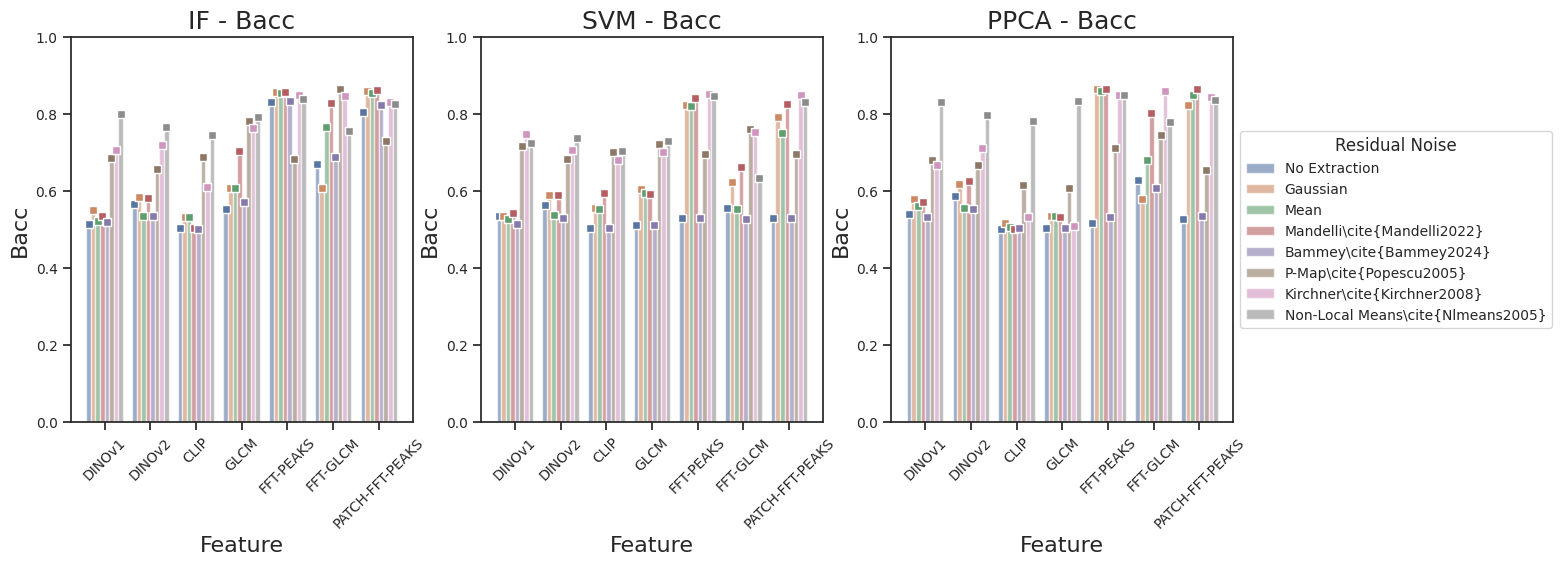

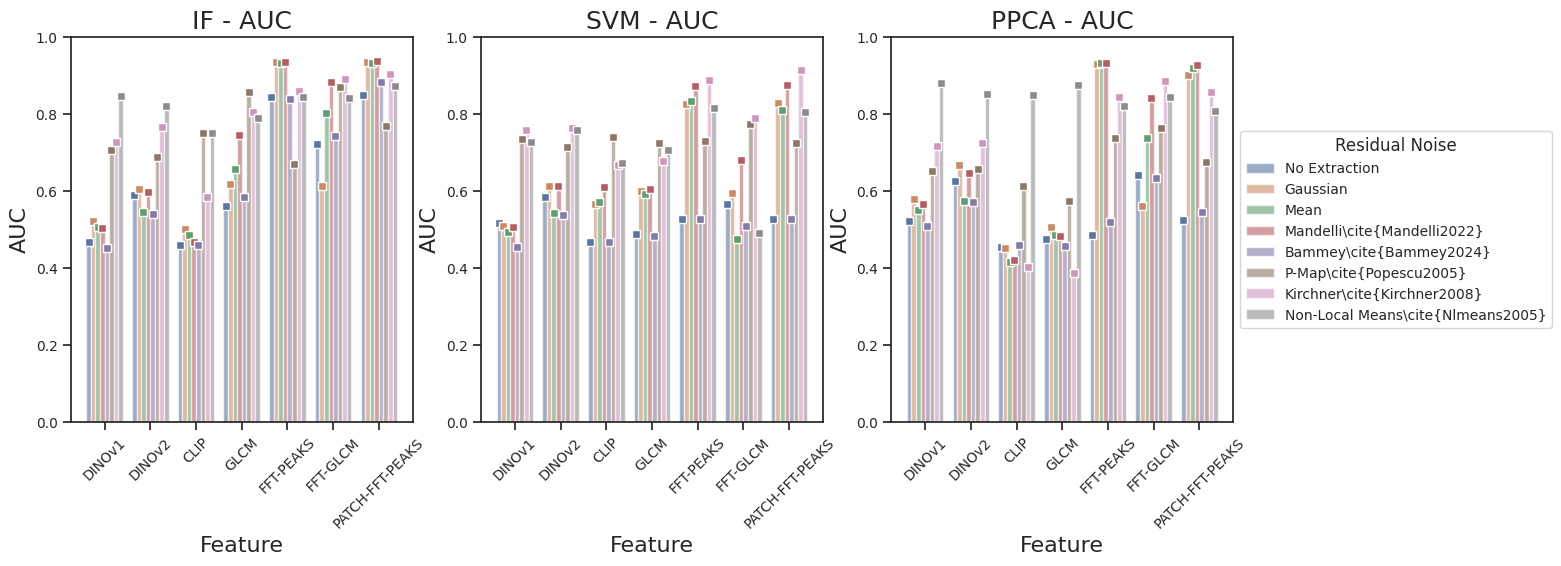

In [27]:
plot_figures(data, "open-set")

----

### Attribution-Set

In [28]:
# Attribution
data = pd.read_csv("../attribution.csv")
if "Unnamed: 0" in data.columns:
    data.drop(columns=["Unnamed: 0"], inplace=True)
results = pd.merge(get_best_results(data, "bcc"), get_best_results(data, "auc"), on=["feat", "classifier"])
results.drop(columns=["filter_x", "filter_y"], inplace=True)
# Mandelli et al results
mandelli_res = highlight_result(data, "Mandelli\cite{Mandelli2022}", "GLCM", "Mandelli et al.\cite{Mandelli2022}")
results = pd.concat([results, mandelli_res])
# Synthbuster results
synthbuster_res = highlight_result(data, "Bammey\cite{Bammey2024}", "FFT-PEAKS", "Synthbuster\cite{Bammey2024}")
results = pd.concat([results, synthbuster_res])
print(results.to_string())

                                  feat       classifier              BCC              AUC
0                            FFT-PEAKS  IsolationForest  0.8080 ± 0.0381  0.8648 ± 0.0021
1                            FFT-PEAKS      OneClassSVM  0.5292 ± 0.0194  0.8032 ± 0.0031
2                            FFT-PEAKS              PCA  0.7475 ± 0.0411  0.8112 ± 0.0015
3                             FFT-GLCM  IsolationForest  0.7461 ± 0.0142  0.8605 ± 0.0029
4                             FFT-GLCM      OneClassSVM  0.3545 ± 0.0083  0.6708 ± 0.0008
5                             FFT-GLCM              PCA  0.5537 ± 0.0273  0.7302 ± 0.0032
6                                 GLCM  IsolationForest  0.8380 ± 0.0211  0.9201 ± 0.0051
7                                 GLCM      OneClassSVM  0.5613 ± 0.0299  0.7963 ± 0.0138
8                                 GLCM              PCA  0.7524 ± 0.0350  0.8518 ± 0.0103
9                               DINOV1  IsolationForest  0.7752 ± 0.0100  0.9079 ± 0.0050
10        

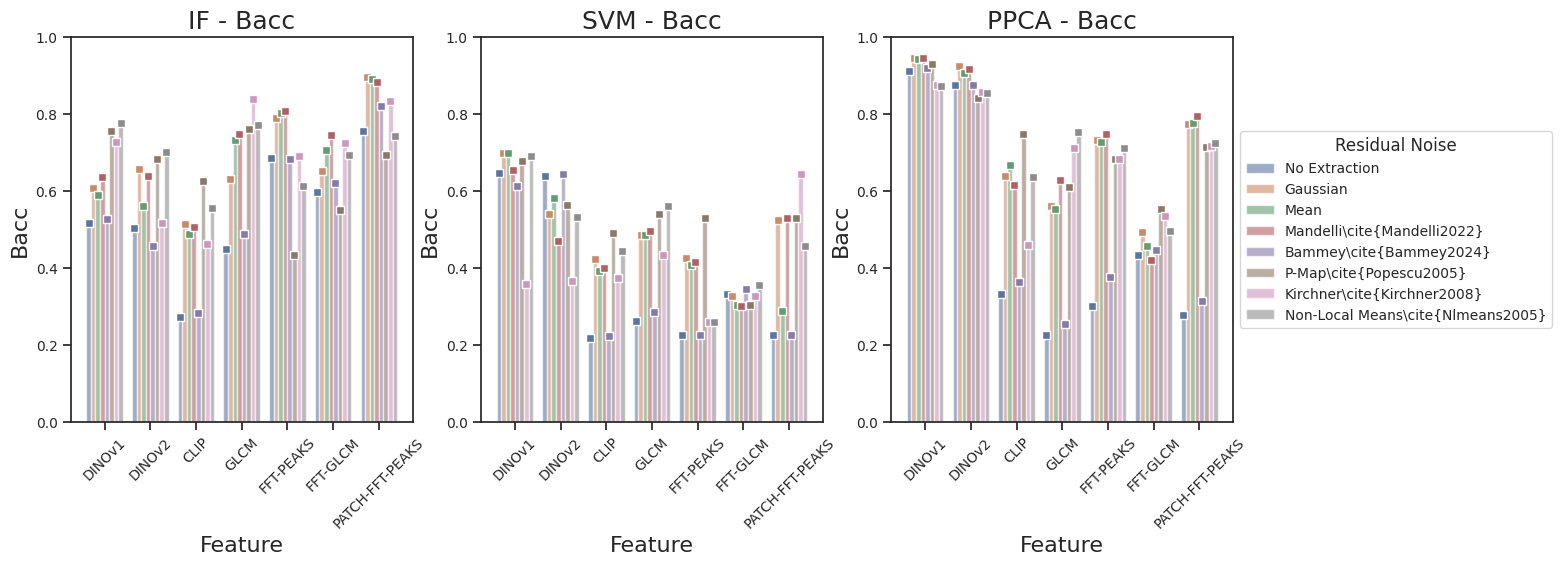

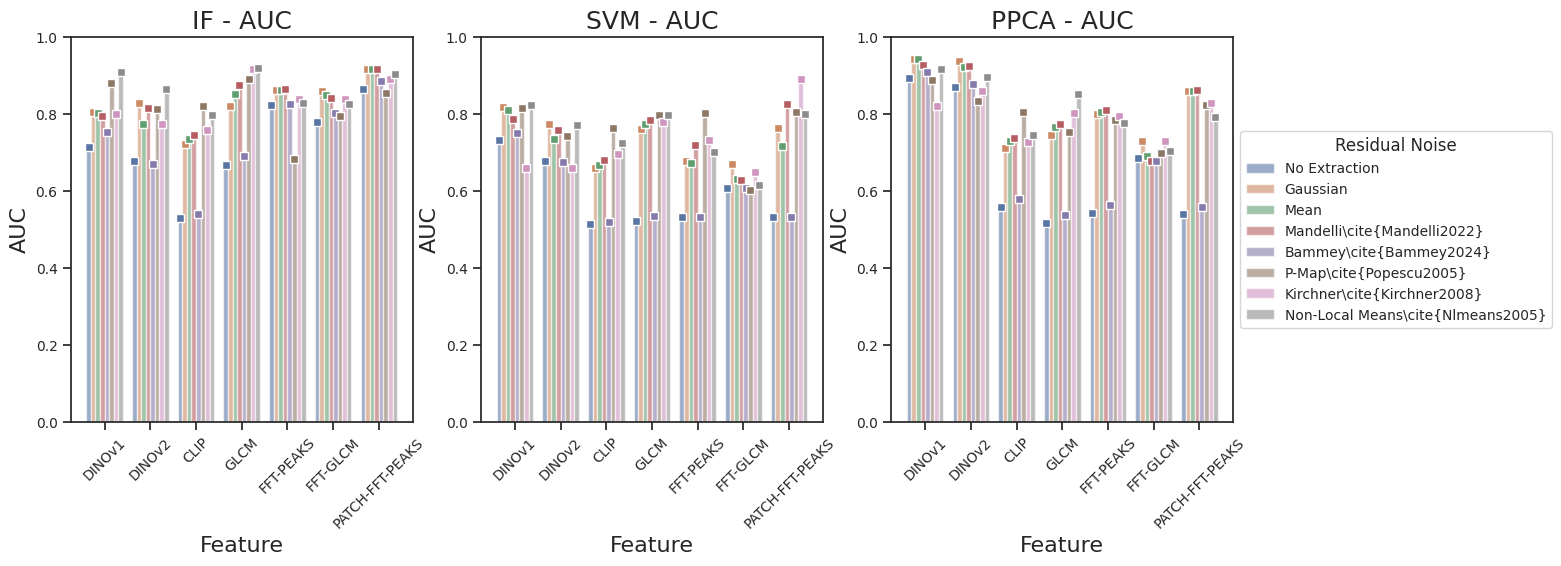

In [29]:
plot_figures(data, "attribution")